# DeepLearning

## MNIST Dataset DeepWater

The MNIST database is a well-known academic dataset used to benchmark
classification performance. The data consists of 60,000 training images and
10,000 test images. Each image is a standardized $28^2$ pixel greyscale image of
a single handwritten digit. An example of the scanned handwritten digits is
shown
![Example MNIST digit images](../../h2o-docs/src/booklets/v2_2015/source/images/mnistdigits.jpg)

In [1]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,1 day 20 hours 55 mins
H2O cluster version:,3.11.0.99999
H2O cluster version age:,2 days
H2O cluster name:,fmilo
H2O cluster total nodes:,1
H2O cluster free memory:,8.85 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,40
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [2]:
test_df = h2o.import_file("https://h2o-public-test-data.s3.amazonaws.com/bigdata/laptop/mnist/test.csv.gz")

Parse progress: |█████████████████████████████████████████████████████████████████████████████| 100%


In [3]:
train_df = h2o.import_file("https://h2o-public-test-data.s3.amazonaws.com/bigdata/laptop/mnist/train.csv.gz")

Parse progress: |█████████████████████████████████████████████████████████████████████████████| 100%


In [4]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator

Specify the response and predictor columns

In [5]:
y = "C785"
x = train_df.names[0:784]

Convert the number to a class

In [6]:
train_df[y] = train_df[y].asfactor()
test_df[y] = test_df[y].asfactor()

Train Deep Learning model and validate on test set

### LeNET 1989

![lenet](./images/lenet.jpg)

In this demo you will learn how to build a simple LeNET Model usix MXNET.

In [28]:
def lenet(num_classes):
    import mxnet as mx
    data = mx.symbol.Variable('data')
    # first conv
    conv1 = mx.symbol.Convolution(data=data, kernel=(5,5), num_filter=20)
    tanh1 = mx.symbol.Activation(data=conv1, act_type="tanh")
    pool1 = mx.symbol.Pooling(data=tanh1, pool_type="max", kernel=(2,2), stride=(2,2))
    # second conv
    conv2 = mx.symbol.Convolution(data=pool1, kernel=(5,5), num_filter=50)
    tanh2 = mx.symbol.Activation(data=conv2, act_type="tanh")
    pool2 = mx.symbol.Pooling(data=tanh2, pool_type="max", kernel=(2,2), stride=(2,2))
    # first fullc
    flatten = mx.symbol.Flatten(data=pool2)
    fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=500)
    tanh3 = mx.symbol.Activation(data=fc1, act_type="tanh")
    # second fullc
    fc2 = mx.symbol.FullyConnected(data=tanh3, num_hidden=num_classes)
    # loss
    lenet = mx.symbol.SoftmaxOutput(data=fc2, name='softmax')
    return lenet

In [29]:
nclasses = 10 

Here we instantiate our lenet model using 10 classes

In [62]:
mxnet_model = lenet(nclasses)

To import the model inside the DeepWater training engine we need to save the model to a file:

In [63]:
model_filename="/tmp/symbol_lenet-py.json"
mxnet_model.save(model_filename)

The model is just the structure of the network expressed as a json dict

In [64]:
!head -n 20 $model_filename

{
  "nodes": [
    {
      "op": "null", 
      "param": {}, 
      "name": "data", 
      "inputs": [], 
      "backward_source_id": -1
    }, 
    {
      "op": "null", 
      "param": {}, 
      "name": "convolution10_weight", 
      "inputs": [], 
      "backward_source_id": -1
    }, 
    {
      "op": "null", 
      "param": {}, 
      "name": "convolution10_bias", 


## Importing the LeNET model architecture for training in H2O

We have defined the model and saved the structure to a file. We are ready to start the training procedure.

In [56]:
from h2o.estimators.deepwater import H2ODeepWaterEstimator

In [57]:
lenet_model = H2ODeepWaterEstimator(
    epochs=10, 
    learning_rate=1e-3, 
    mini_batch_size=64,
    network='user', 
    network_definition_file=model_filename,
    image_shape=[28,28], 
    channels=1
)

In [58]:
lenet_model.train(x=train_df.names, y=y, training_frame=train_df, validation_frame=test_df)

deepwater Model Build progress: |█████████████████████████████████████████████████████████████| 100%


In [60]:
error = lenet_model.model_performance(valid=True).mean_per_class_error()
print "model error:", error

model error: 0.0115251442023


## A More powerful Architecture

the beauty of deeplearning is that we can compose a new model with even more "capacity" to try to get a higher accuracy.

In [45]:
def cnn(num_classes):
    import mxnet as mx
    data = mx.symbol.Variable('data')

    inputdropout = mx.symbol.Dropout(data=data, p=0.1)

    # first convolution
    conv1 = mx.symbol.Convolution(data=data, kernel=(5,5), num_filter=50)
    tanh1 = mx.symbol.Activation(data=conv1, act_type="relu")
    pool1 = mx.symbol.Pooling(data=tanh1, pool_type="max", kernel=(3,3), stride=(2,2))
    
    # second convolution
    conv2 = mx.symbol.Convolution(data=pool1, kernel=(5,5), num_filter=100)
    tanh2 = mx.symbol.Activation(data=conv2, act_type="relu")
    pool2 = mx.symbol.Pooling(data=tanh2, pool_type="max", kernel=(3,3), stride=(2,2))
    
    # first fully connected layer 
    flatten = mx.symbol.Flatten(data=pool2)
    fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=1024)
    relu3 = mx.symbol.Activation(data=fc1, act_type="relu")
    inputdropout = mx.symbol.Dropout(data=fc1, p=0.5)
    
    # second fully connected layer
    flatten = mx.symbol.Flatten(data=relu3)
    fc2 = mx.symbol.FullyConnected(data=flatten, num_hidden=1024)
    relu4 = mx.symbol.Activation(data=fc2, act_type="relu")
    inputdropout = mx.symbol.Dropout(data=fc2, p=0.5)
    
    # third fully connected layer
    fc3 = mx.symbol.FullyConnected(data=relu4, num_hidden=num_classes)
    # loss
    cnn = mx.symbol.SoftmaxOutput(data=fc3, name='softmax')
    return cnn

In [46]:
nclasses = 10

In [48]:
mxnet_model = cnn(nclasses)

In [49]:
model_filename="/tmp/symbol_cnn-py.json"
mxnet_model.save(model_filename)

In [50]:
from h2o.estimators.deepwater import H2ODeepWaterEstimator

In [51]:
print("Importing the lenet model architecture for training in H2O")

Importing the lenet model architecture for training in H2O


In [70]:
model = H2ODeepWaterEstimator(
    epochs=20, 
    learning_rate=1e-3, 
    mini_batch_size=64,
    network='user', 
    network_definition_file=model_filename,
    image_shape=[28,28], 
    channels=1,
    train_samples_per_iteration=1000,
    gpu=True
)

In [71]:
model.train(x=train_df.names, y=y, training_frame=train_df, validation_frame=test_df)

deepwater Model Build progress: |█████████████████████████████████████████████████████████████| 100%


In [72]:
error = model.model_performance(valid=True).mean_per_class_error()
print "model error:", error

model error: 0.0165483476922


## Visualizing the results

In [17]:
%matplotlib inline

import matplotlib
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from IPython.display import Image, display
import warnings
warnings.filterwarnings("ignore")

In [18]:
df = test_df.as_data_frame()

In [19]:
import numpy as np
image = df.T[int(np.random.random()*784)]

In [20]:
image.shape

(785,)

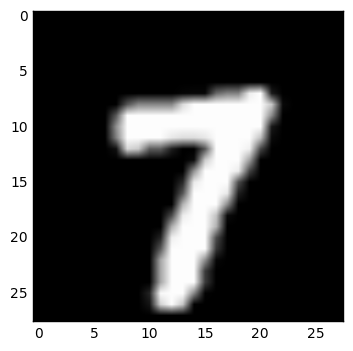

In [21]:
plt.imshow(image[:-1].reshape(28, 28), plt.cm.gray);

In [22]:
print image[-1]

7


In [23]:
image_hf = h2o.H2OFrame.from_python(image.to_dict())

Parse progress: |█████████████████████████████████████████████████████████████████████████████| 100%


In [24]:
prediction = model.predict(image_hf)

deepwater prediction progress: |██████████████████████████████████████████████████████████████| 100%


In [25]:
prediction['predict']

predict
7
